# Определение стоимости автомобилей

## **Описание проекта**

### Постановка задачи

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» активно работает над созданием приложения, цель которого — привлечение новых клиентов. Особенность приложения в том, что пользователи могут мгновенно получить оценку рыночной стоимости своего автомобиля, основываясь на обширной базе данных по продажам автомобилей. Вам предстоит решить ключевую задачу проекта: разработать модель машинного обучения, которая будет предсказывать стоимость автомобиля на основе его характеристик и истории продаж. Эта модель поможет сервису укрепить доверие пользователей, предоставляя им точную и обоснованную оценку стоимости их автомобилей.

Для заказчика важны следующие аспекты:
- Высокое качество предсказаний;
- Минимальное время обучения модели;
- Быстрое время ответа модели на запросы пользователей.

### Описание данных

В вашем распоряжении предоставлены исторические данные о продажах автомобилей, включая технические характеристики, комплектации и фактические цены продаж. Эти данные выглядят следующим образом:

**Признаки:**
- `DateCrawled` — дата скачивания анкеты из базы;
- `VehicleType` — тип автомобильного кузова;
- `RegistrationYear` — год регистрации автомобиля;
- `Gearbox` — тип коробки передач;
- `Power` — мощность двигателя в лошадиных силах;
- `Model` — модель автомобиля;
- `Kilometer` — пробег автомобиля в километрах;
- `RegistrationMonth` — месяц регистрации автомобиля;
- `FuelType` — тип используемого топлива;
- `Brand` — марка автомобиля;
- `Repaired` — информация о проведенных ремонтных работах;
- `DateCreated` — дата создания анкеты;
- `NumberOfPictures` — количество фотографий автомобиля в анкете;
- `PostalCode` — почтовый индекс владельца анкеты;
- `LastSeen` — дата последней активности пользователя.

**Целевой признак:**
- `Price` — цена автомобиля в евро.

Цель проекта — создать модель, способную с высокой точностью предсказывать стоимость автомобиля на рынке. Это позволит пользователям сервиса «Не бит, не крашен» быстро и надежно оценивать стоимость своих автомобилей, улучшая пользовательский опыт и повышая лояльность к сервису.


### Задачи исследования:

- Этап 1. Разведочный анализ данных (EDA);
- Этап 2. Предобработка данных;
- Этап 3. Подготовка данных к обучению;
- Этап 4. Обучение моделей;
- Этап 5. Анализ моделей;
- Этап 6. Тестирование наилучшей модели;
- Общий вывод.

### Этап 1. Разведочный анализ данных (EDA):

#### Импорт библиотек

In [1]:
# !pip install -q seaborn catboost lightgbm

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    cross_val_score,
    RandomizedSearchCV,
    train_test_split
)    
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.tree import DecisionTreeRegressor
from time import time
%matplotlib notebook
%matplotlib inline

In [2]:
# Отключение warning
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
#Формат float
pd.options.display.float_format = '{:,.2f}'.format
# Сброс ограничений на число столбцов
pd.options.display.max_columns = None

#### Информация о столбцах:

In [3]:
data_name = 'Объявления о продаже автомобилей'

data_fields = { 'DateCrawled'      :['дата скачивания анкеты из базы', False],
                'VehicleType'      :['тип автомобильного кузова', False],
                'RegistrationYear' :['год регистрации автомобиля', True],
                'Gearbox'          :['тип коробки передач', True],
                'Power'            :['мощность (л. с.)', True],
                'Model'            :['модель автомобиля',  False],
                'Kilometer'        :['пробег (км)', True],
                'RegistrationMonth':['месяц регистрации автомобиля', False],
                'FuelType'         :['тип топлива', False],
                'Brand'            :['марка автомобиля',  False],
                'Repaired'         :['была машина в ремонте или нет', False],
                'DateCreated'      :['дата создания анкеты', False],
                'NumberOfPictures' :['количество фотографий автомобиля', False],
                'PostalCode'       :['почтовый индекс владельца анкеты (пользователя)', False],
                'LastSeen'         :['дата последней активности пользователя', False],
                'Price'            :['цена (евро)', True]
}

#### Функция получения информации о столбце

In [4]:
def col_reaper(ddf, param_name, plot_hist=True):
    """
    Функция для анализа распределения значений в столбце DataFrame.

    Осуществляет вывод описательной статистики для указанного столбца,
    строит гистограмму значений для количественных данных или распределение
    уникальных значений для категориальных данных, если это указано в параметрах.

    Параметры:
    ddf (pandas.DataFrame): DataFrame, в котором производится анализ.
    param_name (str): Имя столбца в DataFrame для анализа.
    plot_hist (bool, optional): Флаг, указывающий, нужно ли строить гистограмму
                                значений. По умолчанию True.

    Возвращает:
    None: Функция только выводит результаты анализа и графики, не возвращая значений.
    """
    global data_fields
    data_len = len(ddf)
    param = ddf[param_name]
    
    # Определение имени столбца
    if data_fields.get(param_name)[0] is not None:
        field = data_fields.get(param_name)[0]
    else:
        field = ''
        
    # Описание данных
    print('\n\033[4m'+'Описание данных:'+ '\033[0m')
    print(param.describe(datetime_is_numeric=True))
    typer = type(param[0])
    print('\033[4m' + 'Количество записей:' + '\033[0m', sum(param.notna()), 'из', data_len)
    if sum(param.isna()) > 0:
        print('\033[4m' + 'Пропущено:' + '\033[0m', sum(param.isna()))
        print('')

    # Построение гистограммы
    print('\033[4m'+'\nТип:\n' + '\033[0m', typer)
    if plot_hist and not 'str' in str(typer):
        print('\033[4m'+'\nГистограмма значений:'+ '\033[0m')
        param.plot(kind='hist', bins=20, figsize=(12, 5), grid=True)
        plt.title(field)
        plt.ylabel('Количество записей')
        plt.xticks(rotation=0)
        plt.show()
    else:
        if len(param.unique()) <= 40:
            print('\033[4m'+'\nРаспределение уникальных значений (первые 10 значений в порядке убывания):'+ '\033[0m')
            param_group = ddf.groupby(param_name).agg(cnt=(param_name, 'count')).reset_index()
            display(param_group.sort_values(by='cnt', ascending=False).reset_index(drop=True).head(10))
            print('\033[4m'+'\nГистограмма значений:'+ '\033[0m')
            param_group.plot(x=param_name, y='cnt', kind='bar', figsize=(12, 5))
            plt.title(field)
            plt.ylabel('Количество записей')
            if len(param.unique()) <= 20:
                plt.xticks(rotation=0)
            else:
                plt.xticks(rotation=90)
            plt.show()
    print('')

#### Функция получения информации о датафрейме

In [5]:
def df_reaper(df, df_name='', data_fields={}):
    """
    Функция для комплексного анализа DataFrame, включая вывод общей информации,
    анализ дубликатов, описание статистик для числовых столбцов, построение диаграмм рассеивания
    и корреляционной матрицы для выбранных столбцов, а также детальный анализ каждого столбца.

    Параметры:
    df (pandas.DataFrame): DataFrame для анализа.
    df_name (str, optional): Название DataFrame для вывода в заголовке. По умолчанию пустая строка.
    data_fields (dict, optional): Словарь, описывающий поля данных. Для каждого поля может быть
                                  указано его название и необходимость построения гистограммы.
                                  По умолчанию пустой словарь.

    Возвращает:
    None: Функция только выводит результаты анализа и графики, не возвращая значений.
    """
    # Список столбцов для анализа
    cols = df.columns
    true_cols = [col for col in cols if data_fields.get(col) and data_fields.get(col)[1]]

    print('\033[1;4m' + df_name + '\033[0m \n')   
    print('\033[1m' + 'Количество записей:' + '\033[0m')   
    df_len = len(df)
    display(df_len)
    print('')
    
    print('\033[1m' + 'Первые 5 строк данных:' + '\033[0m')   
    display(df.head())
    print('')
    
    print('\033[1m' + 'Информация о датафрейме:' + '\033[0m')
    print('')
    display(df.info())
    
    print('\033[1m' + 'Дубликаты:' + '\033[0m')
    if df.duplicated().sum() > 0:
        print('Обнаружено дубликатов:', df.duplicated().sum())
    else:    
        print('Дубликатов не обнаружено')
    print('')
    
    print('\033[1m' + 'Описание данных в столбцах с числовыми значениями:' + '\033[0m')
    display(df.describe().T)

    print('\033[1m' + 'Диаграмма рассеивания:' + '\033[0m')
    pd.plotting.scatter_matrix(df[true_cols], figsize=(16, 16)); 
    plt.show()
    
    print('\033[1m' + 'Корелляция данных:' + '\033[0m')
    plt.figure(figsize=(16, 6))
    mask = np.triu(np.ones_like(df[true_cols].corr(), dtype=bool))
    heatmap = sns.heatmap(df[true_cols].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    plt.show()
    
    print('\033[1m' + 'Столбцы:' + '\033[0m \n')
    for col in cols:
        field = data_fields.get(col)[0] if data_fields.get(col) and data_fields.get(col)[0] is not None else ''
        print('\033[1;3m' + col + ' - ' + field + '\033[0m')
        plot_hist = data_fields.get(col)[1] if data_fields.get(col) else False
        col_reaper(df, col, plot_hist)

#### Функция заполнения пропуска в данных

Функция **friendly_filler** ищет в датафрейме **df** строки с пропущенными значениями столбца **target**, <br />
для которых в **df** есть строки с таким же значением столбца **base** c непустыми значениями,<br />
и заполняет их в зависимости от значения параметра **agg**:
- *'none'* (по умолчанию) - первым непустым значением;
- *'mode'* - наиболее популярным значением;
- *'median'* - медианным значением;
- *'mean'* - средним значением.

In [6]:
def friendly_filler(df, base, target, agg='none'):
    """
    Заполняет пропущенные значения в целевом столбце (`target`) DataFrame (`df`) на основе
    уникальных значений в базовом столбце (`base`). Метод заполнения определяется параметром `agg`,
    который может принимать значения 'none', 'mode', 'median' или 'mean'.

    Параметры:
    df (pandas.DataFrame): DataFrame для обработки.
    base (str): Имя столбца, на основе уникальных значений которого будет производиться заполнение.
    target (str): Имя целевого столбца, в котором необходимо заполнить пропущенные значения.
    agg (str, optional): Метод агрегации для заполнения пропущенных значений. 
                         'none' - использовать первое встречное непропущенное значение (по умолчанию),
                         'mode' - использовать моду,
                         'median' - использовать медиану,
                         'mean' - использовать среднее значение.

    Возвращает:
    pandas.DataFrame: DataFrame с заполненными пропущенными значениями в целевом столбце.
    """
    # Получение уникальных значений базового столбца с пропущенными и непропущенными значениями целевого столбца
    target_no = df.query(target + '.isna()')[base].unique()
    target_yes = df.query(target + '.notna()')[base].unique()
    target_yes_no = pd.Series(list(set(target_yes).intersection(set(target_no))))
    
    for t in target_yes_no:
        if agg == 'none':
            x = list(df[(df[base] == t) & (df[target].notna())][target])[0]
        elif agg == 'mode':
            x = df[(df[base] == t) & (df[target].notna())][target].mode()[0]
        elif agg == 'median':
            x = df[(df[base] == t) & (df[target].notna())][target].median()
        elif agg == 'mean':
            x = df[(df[base] == t) & (df[target].notna())][target].mean()
            
        # Заполнение пропущенных значений найденным значением
        df.loc[(df[base] == t) & (df[target].isna()), target] = x
    
    return df

#### Загрузка данных

In [7]:
try:
    data = pd.read_csv('./autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

#### Анализ датасета

Объявления о продаже автомобилей 

Количество записей:


354369


Первые 5 строк данных:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  objec

None

Дубликаты:
Обнаружено дубликатов: 4

Описание данных в столбцах с числовыми значениями:


,count,mean,std,min,25%,50%,75%,max
Price,"354,369.00","4,416.66","4,514.16",0.00,"1,050.00","2,700.00","6,400.00","20,000.00"
RegistrationYear,"354,369.00","2,004.23",90.23,"1,000.00","1,999.00","2,003.00","2,008.00","9,999.00"
Power,"354,369.00",110.09,189.85,0.00,69.00,105.00,143.00,"20,000.00"
Kilometer,"354,369.00","128,211.17","37,905.34","5,000.00","125,000.00","150,000.00","150,000.00","150,000.00"
RegistrationMonth,"354,369.00",5.71,3.73,0.00,3.00,6.00,9.00,12.00
NumberOfPictures,"354,369.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
PostalCode,"354,369.00","50,508.69","25,783.10","1,067.00","30,165.00","49,413.00","71,083.00","99,998.00"


Диаграмма рассеивания:


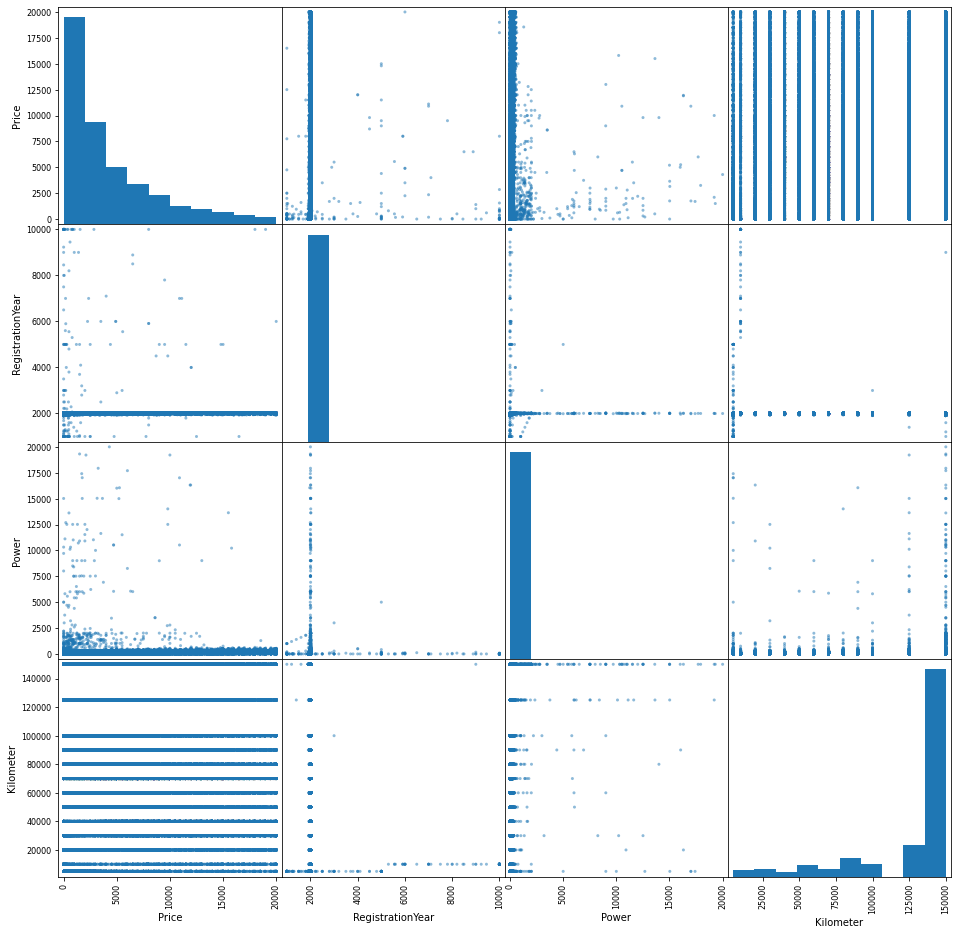

Корелляция данных:


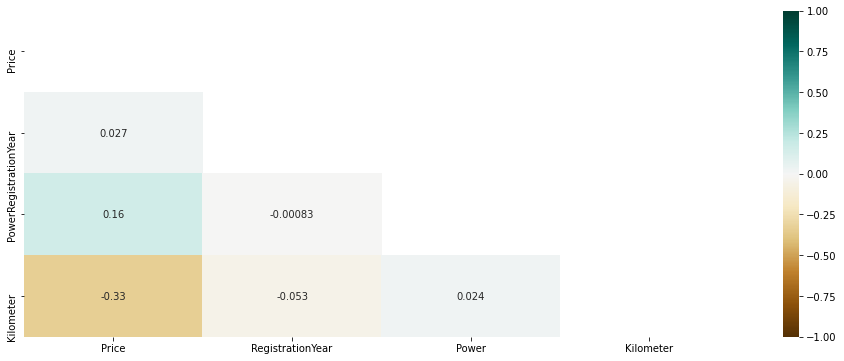

Столбцы: 

DateCrawled - дата скачивания анкеты из базы

Описание данных:
count                  354369
unique                 271174
top       2016-03-24 14:49:47
freq                        7
Name: DateCrawled, dtype: object
Количество записей: 354369 из 354369

Тип:
 <class 'str'>

Price - цена (евро)

Описание данных:
count   354,369.00
mean      4,416.66
std       4,514.16
min           0.00
25%       1,050.00
50%       2,700.00
75%       6,400.00
max      20,000.00
Name: Price, dtype: float64
Количество записей: 354369 из 354369

Тип:
 <class 'numpy.int64'>

Гистограмма значений:


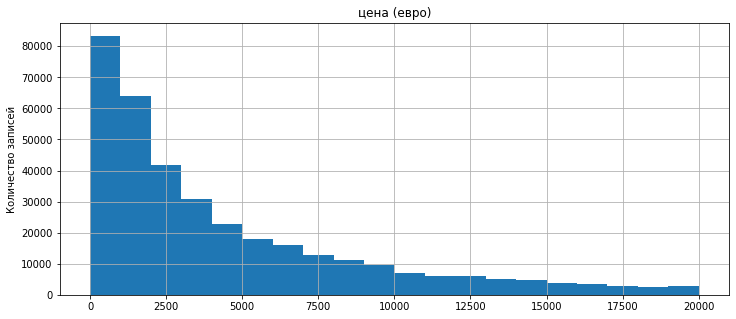


VehicleType - тип автомобильного кузова

Описание данных:
count     316879
unique         8
top        sedan
freq       91457
Name: VehicleType, dtype: object
Количество записей: 316879 из 354369
Пропущено: 37490


Тип:
 <class 'float'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,VehicleType,cnt
0,sedan,91457
1,small,79831
2,wagon,65166
3,bus,28775
4,convertible,20203
5,coupe,16163
6,suv,11996
7,other,3288



Гистограмма значений:


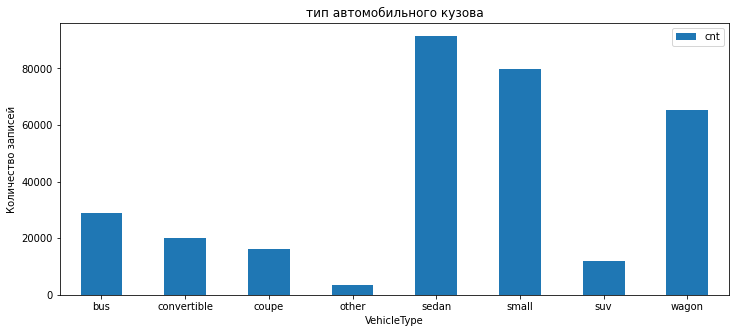


RegistrationYear - год регистрации автомобиля

Описание данных:
count   354,369.00
mean      2,004.23
std          90.23
min       1,000.00
25%       1,999.00
50%       2,003.00
75%       2,008.00
max       9,999.00
Name: RegistrationYear, dtype: float64
Количество записей: 354369 из 354369

Тип:
 <class 'numpy.int64'>

Гистограмма значений:


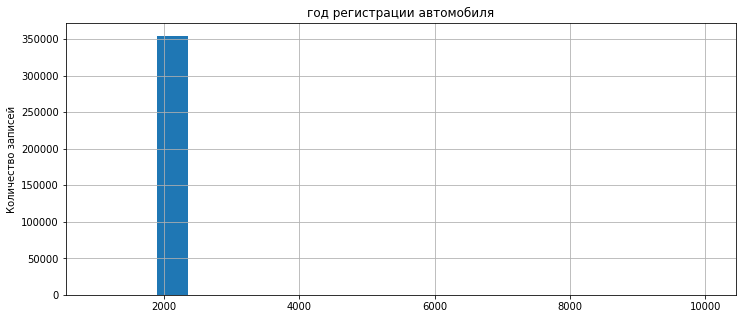


Gearbox - тип коробки передач

Описание данных:
count     334536
unique         2
top       manual
freq      268251
Name: Gearbox, dtype: object
Количество записей: 334536 из 354369
Пропущено: 19833


Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,Gearbox,cnt
0,manual,268251
1,auto,66285



Гистограмма значений:


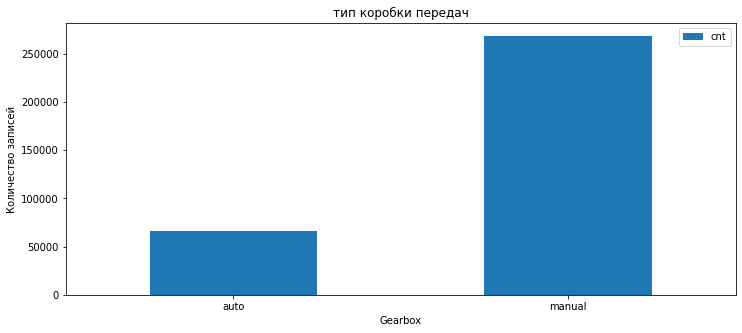


Power - мощность (л. с.)

Описание данных:
count   354,369.00
mean        110.09
std         189.85
min           0.00
25%          69.00
50%         105.00
75%         143.00
max      20,000.00
Name: Power, dtype: float64
Количество записей: 354369 из 354369

Тип:
 <class 'numpy.int64'>

Гистограмма значений:


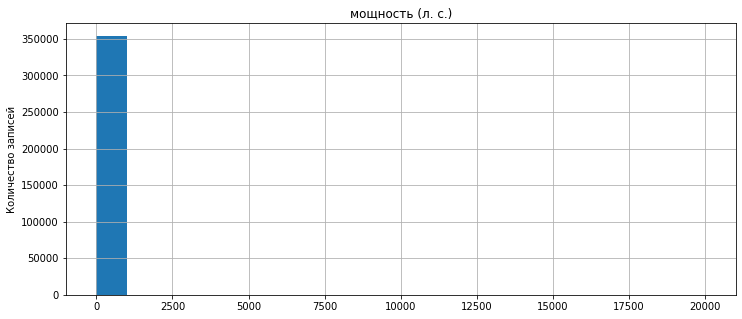


Model - модель автомобиля

Описание данных:
count     334664
unique       250
top         golf
freq       29232
Name: Model, dtype: object
Количество записей: 334664 из 354369
Пропущено: 19705


Тип:
 <class 'str'>

Kilometer - пробег (км)

Описание данных:
count   354,369.00
mean    128,211.17
std      37,905.34
min       5,000.00
25%     125,000.00
50%     150,000.00
75%     150,000.00
max     150,000.00
Name: Kilometer, dtype: float64
Количество записей: 354369 из 354369

Тип:
 <class 'numpy.int64'>

Гистограмма значений:


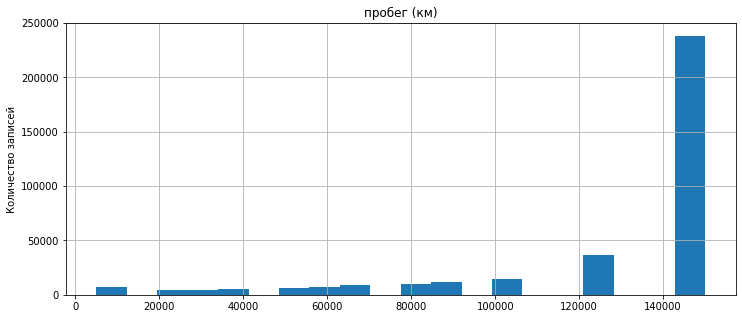


RegistrationMonth - месяц регистрации автомобиля

Описание данных:
count   354,369.00
mean          5.71
std           3.73
min           0.00
25%           3.00
50%           6.00
75%           9.00
max          12.00
Name: RegistrationMonth, dtype: float64
Количество записей: 354369 из 354369

Тип:
 <class 'numpy.int64'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,RegistrationMonth,cnt
0,0,37352
1,3,34373
2,6,31508
3,4,29270
4,5,29153
5,7,27213
6,10,26099
7,12,24289
8,11,24186
9,9,23813



Гистограмма значений:


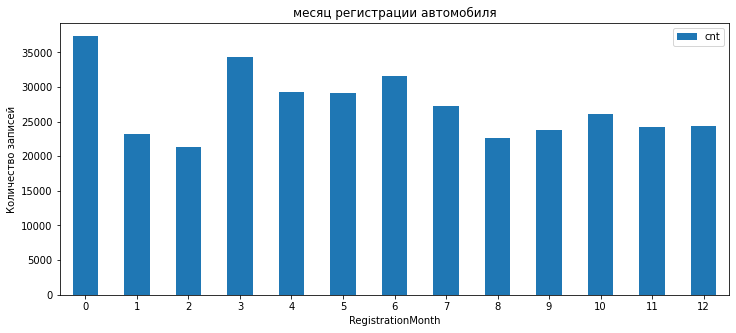


FuelType - тип топлива

Описание данных:
count     321474
unique         7
top       petrol
freq      216352
Name: FuelType, dtype: object
Количество записей: 321474 из 354369
Пропущено: 32895


Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,FuelType,cnt
0,petrol,216352
1,gasoline,98720
2,lpg,5310
3,cng,565
4,hybrid,233
5,other,204
6,electric,90



Гистограмма значений:


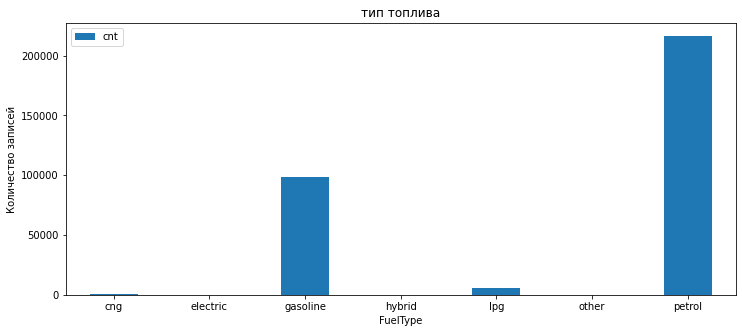


Brand - марка автомобиля

Описание данных:
count         354369
unique            40
top       volkswagen
freq           77013
Name: Brand, dtype: object
Количество записей: 354369 из 354369

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,Brand,cnt
0,volkswagen,77013
1,opel,39931
2,bmw,36914
3,mercedes_benz,32046
4,audi,29456
5,ford,25179
6,renault,17927
7,peugeot,10998
8,fiat,9643
9,seat,6907



Гистограмма значений:


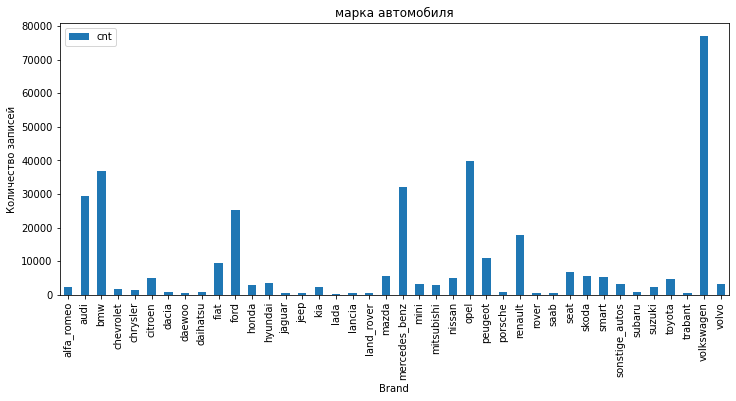


Repaired - была машина в ремонте или нет

Описание данных:
count     283215
unique         2
top           no
freq      247161
Name: Repaired, dtype: object
Количество записей: 283215 из 354369
Пропущено: 71154


Тип:
 <class 'float'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,Repaired,cnt
0,no,247161
1,yes,36054



Гистограмма значений:


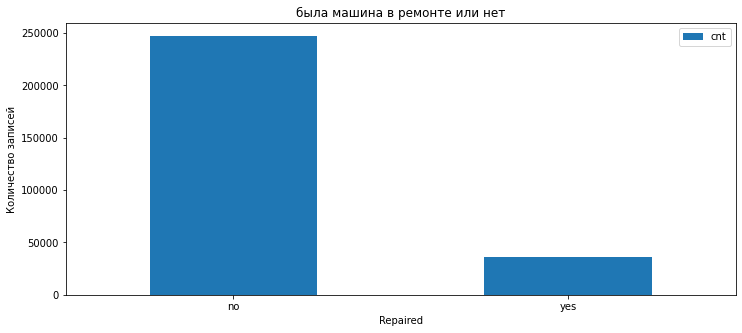


DateCreated - дата создания анкеты

Описание данных:
count                  354369
unique                    109
top       2016-04-03 00:00:00
freq                    13719
Name: DateCreated, dtype: object
Количество записей: 354369 из 354369

Тип:
 <class 'str'>

NumberOfPictures - количество фотографий автомобиля

Описание данных:
count   354,369.00
mean          0.00
std           0.00
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           0.00
Name: NumberOfPictures, dtype: float64
Количество записей: 354369 из 354369

Тип:
 <class 'numpy.int64'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,NumberOfPictures,cnt
0,0,354369



Гистограмма значений:


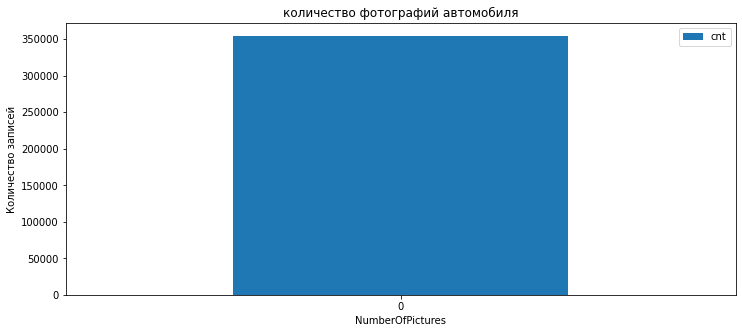


PostalCode - почтовый индекс владельца анкеты (пользователя)

Описание данных:
count   354,369.00
mean     50,508.69
std      25,783.10
min       1,067.00
25%      30,165.00
50%      49,413.00
75%      71,083.00
max      99,998.00
Name: PostalCode, dtype: float64
Количество записей: 354369 из 354369

Тип:
 <class 'numpy.int64'>

LastSeen - дата последней активности пользователя

Описание данных:
count                  354369
unique                 179150
top       2016-04-06 13:45:54
freq                       17
Name: LastSeen, dtype: object
Количество записей: 354369 из 354369

Тип:
 <class 'str'>



In [8]:
df_reaper(data, data_name, data_fields)

#### Итоги анализа данных:
1. Датасет содержит 354369 записей
2. Присутствует 4 полных дубликата
3. Часть признаков (VehicleType, Model, FuelType, Gearbox, Repaired) содержит пропуски
4. Присутствует  слабая обратная корелляция между пробегом и ценой, а также очень слабая корреляция между мощностью двигателя и ценой
5. Требуется приведение типов:
- DateCrawled - к типу DateTime;
- RegistrationYear, RegistrationMonth - объединить 
- DateCreated - к типу DateTime;
- PostalCode - к типу string, добавить лидирующие нули до 6 символов
- Repaired - к типу boolean;
- LastSeen - к типу DateTime.
6. NumberOfPictures содержит только нулевые данные
7. признаки RegistrationYear, Power содержат сбойные данные (RegistrationMonth - 13 месяцев, Power - мощность 0 и 20000 л.с.

### Этап 2. Предобработка данных

#### Дубликаты данных

In [9]:
data[data.duplicated(keep=False)].sort_values(by='Price')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54


- Похоже, это действительно дубликаты - их можно удалить

In [10]:
data = data.drop_duplicates()

In [11]:
data.duplicated().sum()

0

#### Преобразование типов данных

In [12]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


#### Преобразование временных признаков

In [13]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data['DateCrawled'].head()

0   2016-03-24 11:52:17
1   2016-03-24 10:58:45
2   2016-03-14 12:52:21
3   2016-03-17 16:54:04
4   2016-03-31 17:25:20
Name: DateCrawled, dtype: datetime64[ns]

In [14]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data['DateCrawled'].head()

0   2016-03-24 11:52:17
1   2016-03-24 10:58:45
2   2016-03-14 12:52:21
3   2016-03-17 16:54:04
4   2016-03-31 17:25:20
Name: DateCrawled, dtype: datetime64[ns]

In [15]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data['DateCreated'].head()

0   2016-03-24
1   2016-03-24
2   2016-03-14
3   2016-03-17
4   2016-03-31
Name: DateCreated, dtype: datetime64[ns]

In [16]:
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d %H:%M:%S')
data['LastSeen'].head()

0   2016-04-07 03:16:57
1   2016-04-07 01:46:50
2   2016-04-05 12:47:46
3   2016-03-17 17:40:17
4   2016-04-06 10:17:21
Name: LastSeen, dtype: datetime64[ns]

#### Данные о регистрации

- Максимальный год скачивания анкеты 2016;
- Часть автомобилей зарегистрированны в будущем - после ее скачивания.

In [17]:
len(data.query('RegistrationYear > 2016'))

14530

- а часть в 11-19 веках:

In [18]:
len(data.query('RegistrationYear < 1900'))

66

- Поскольку цена на такие автомобили непредсказуема - записи о них тоже придется удалить!

In [19]:
data = data[(data['RegistrationYear'] >= 1900) & (data['RegistrationYear'] <= 2016)]

In [20]:
np.sort(data['RegistrationMonth'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

У признака RegistrationMonth 13 значений. И каждому из значений большое количество записей.<br>
Есть два варианта причины этого:
1. Сливали 2 базы данных, в одной месяцы нумеровали от 0, а во второй - от 1
2. 0 помечены те объявления, где не был указан масяц.<br />
Поскольку нет возможности уточнить это у постановщика задачи, примем за рабочий второй вариант, как более вероятный.<br />
В этом случае стоит поступить по правилу, которым руководствуются страховые компании: если месяц не указан, значит это январь.

Кроме того, для модели будет хорошо, если мы объединим месяц и год регистрации в 1 признак: количество месяцев от какой-либо даты, например 1 января 1900 года.

Пересчёт месяца в число:

In [21]:
def month_to_int(row):
    """
    Преобразует месяц и год регистрации из строковых или числовых значений в одно числовое значение,
    представляющее количество месяцев с 1900 года. Это преобразование может быть полезно для
    анализа временных рядов или сортировки данных по дате, когда требуется одномерный числовой формат.

    Параметры:
    row (pandas.Series): Строка DataFrame, содержащая данные по месяцу и году регистрации.
                         Предполагается, что в этой строке есть ключи 'RegistrationMonth' и 'RegistrationYear'.

    Возвращает:
    pandas.Series: Исходная строка с добавленным новым ключом 'reg_month', содержащим преобразованное значение.
    """
    month = row['RegistrationMonth']
    # Если месяц регистрации равен 0, принимаем его за январь (1 месяц)
    if month == 0:
        month = 1
    # Рассчитываем количество лет с 1900 года
    years = row['RegistrationYear'] - 1900
    # Рассчитываем общее количество месяцев с 1900 года
    row['reg_month'] = years * 12 + month - 1
    return row

In [22]:
%%time
data = data.apply(month_to_int, axis=1)

CPU times: user 3min 12s, sys: 1.47 s, total: 3min 14s
Wall time: 3min 14s


In [23]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,reg_month
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57,1116
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,1336
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46,1255
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,1217
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,1302


#### Преобразование PostalCode в текст

Индексы состоят из чисел, и модель может индекс за числовой параметр. Чтобы этого не допустить, сделаем его текстом

In [24]:
def indexer(row):
    """
    Дополняет почтовый индекс нулями слева до длины в 6 символов. Это необходимо для стандартизации
    формата почтовых индексов, особенно если они изначально представлены в числовом формате и ведущие нули были потеряны.

    Параметры:
    row (pandas.Series): Строка DataFrame, содержащая данные почтового индекса в ключе 'PostalCode'.

    Возвращает:
    pandas.Series: Исходная строка с модифицированным ключом 'PostalCode', где почтовый индекс дополнен нулями слева до 6 символов.
    """
    PostalCode = str(row['PostalCode'])
    # Дополнение индекса нулями слева до общей длины в 6 символов
    index = PostalCode.zfill(6)
    row['PostalCode'] = index
    return row

In [25]:
%%time
data = data.apply(indexer, axis=1)
data['PostalCode'].head()

CPU times: user 23.9 s, sys: 96.1 ms, total: 24 s
Wall time: 24 s


0    070435
1    066954
2    090480
3    091074
4    060437
Name: PostalCode, dtype: object

#### Преобразование Repaired в Bool

In [26]:
data['Repaired'] = data['Repaired'].astype(bool)
data['Repaired'].head()

0    True
1    True
2    True
3    True
4    True
Name: Repaired, dtype: bool

#### Результат преобразования типов

In [27]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,reg_month
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,True,2016-03-24,0,070435,2016-04-07 03:16:57,1116
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,True,2016-03-24,0,066954,2016-04-07 01:46:50,1336
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,True,2016-03-14,0,090480,2016-04-05 12:47:46,1255
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,True,2016-03-17,0,091074,2016-03-17 17:40:17,1217
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,True,2016-03-31,0,060437,2016-04-06 10:17:21,1302


#### Пропущенные данные

Признаки VehicleType, Model, FuelType, Repaired содержит пропуски

Функция **friendly_filler** ищет в датафрейме **df** строки с пропущенными значениями столбца **target**, <br />
для которых в **df** есть строки с таким же значением столбца **base** c непустыми значениями,<br />
и заполняет их в зависимости от значения параметра **agg**:
- *'none'* (по умолчанию) - первым непустым значением;
- *'mode'* - наиболее популярным значением;
- *'median'* - медианным значением;
- *'mean'* - средним значением.

#### Model

In [28]:
data.query('Model.isna()').head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,reg_month
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,True,2016-03-24,0,066954,2016-04-07 01:46:50,1336
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,True,2016-03-29,0,053721,2016-04-06 01:44:38,1138
81,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,True,2016-04-03,0,045665,2016-04-05 11:47:13,1166
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,True,2016-03-20,0,037520,2016-04-07 02:45:22,1188
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,True,2016-03-27,0,038709,2016-04-05 20:17:31,1104


In [29]:
len(data.query('Model.isna()'))

17625

- У 5% данных отсутствуют данные о модели ТС. Такие данные очень трудно восстановить, поэтому их придется удалить.

In [30]:
data = data.dropna(subset=['Model'])

In [31]:
len(data.query('Model.isna()'))

0

#### VehicleType

In [32]:
len(data.query('VehicleType.isna()'))

18165

- 6 процентов данных;
- Попробуем заполнить данные наиболее популярными значениями для каждой из моделей.

In [33]:
data = friendly_filler(data,'Model','VehicleType','mode')

In [34]:
len(data.query('VehicleType.isna()'))

0

- Все пропуски в признаке VehicleType заполнены.

#### FuelType

In [35]:
len(data.query('FuelType.isna()'))

21187

- Попробуем заполнить данные наиболее популярными значениями для каждой из моделей.

In [36]:
data = friendly_filler(data,'Model','FuelType','mode')

In [37]:
len(data.query('FuelType.isna()'))

0

- Все пропуски в признаке FuelType заполнены.

Посмотрим на то, какие виды топлива присутствуют у машин:

In [38]:
data['FuelType'].unique()

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

- "petrol" и "gasoline" - это синонимы, в переводе - "бензин". Налицо - не явный дубликат.

In [39]:
data.loc[data['FuelType'] == 'gasoline','FuelType'] = 'petrol'

#### Gearbox

In [40]:
len(data.query('Gearbox.isna()'))

14225

- Попробуем заполнить данные наиболее популярными значениями для каждой из моделей.

In [41]:
data = friendly_filler(data,'Model','Gearbox','mode')

In [42]:
len(data.query('Gearbox.isna()'))

0

- Все пропуски в признаке Gearbox заполнены.

#### Repaired

In [43]:
len(data.query('Repaired.isna()'))

0

- Все пропущенные данные удалены раньше.

#### Итог обработки пропусков:

Проверка пропусков в датасете:

In [44]:
data.isna().sum().sum()

0

- Пропущенных данных нет.

#### Аномальные значения

В поле Power присутствуют анормально высокие и аномально низкие значения

Можно, конечно предположить, что среди объявлений есть суперкары, но, с большей вероятностью, владельцы указали в объявлениях не мощность, а объём двигателя.<br />
Граничным значением можно считать 650 - все двигатели имеют объём больше, чем 650 куб.см, а автомобили мощьностью больше 650 л.с можно по пальцам пересчитать

In [45]:
len(data.query('Power > 650'))

289

Посмотрим, какие бренды претендуют на мощь:

In [46]:
data.query('Power > 650')['Brand'].unique()

array(['toyota', 'opel', 'mitsubishi', 'fiat', 'volkswagen', 'ford',
       'seat', 'bmw', 'nissan', 'mercedes_benz', 'citroen', 'skoda',
       'volvo', 'chevrolet', 'peugeot', 'smart', 'audi', 'kia', 'renault',
       'chrysler', 'mazda', 'suzuki', 'mini', 'alfa_romeo', 'honda',
       'daewoo', 'hyundai', 'lancia'], dtype=object)

Посмотрим теперь на машины тех из них, которые реально имеют в своей линейке машины с двигателями больше 1000 л.с.

In [47]:
top_brand = ['bmw','nissan', 'mercedes_benz''mini']

In [48]:
data.query('(Power > 650) and Brand in @top_brand')[['Brand','Model','Power']].sort_values(by=['Brand','Model'])

,Brand,Model,Power
91568,bmw,1er,1223
114106,bmw,1er,19211
22281,bmw,3er,1993
78059,bmw,3er,1500
79981,bmw,3er,2016
80682,bmw,3er,1436
148269,bmw,3er,1506
177706,bmw,3er,1103
187330,bmw,3er,17019
188785,bmw,3er,1895


У BMW самый мощный серийный двигатель 626 л.с., а уж у Nissan Micra....

Следовательно, записи, у которых Power > 650, сбойные.

Аналогично, посмотрим на модели с неожиданно низкой мощностью двигателя

Рассмотрим сначала нулевые значения:

In [49]:
len(data.query('Power == 0'))

30886

У этих машин скорее всего нет информации по мощности двигателя. 

Мощность двигателя "Оки" была 29 л.с. Скорее всего, меньше 25 л.с. сейчас машин не найти....

In [50]:
data.query('(Power > 0) and (Power < 25) ').head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,reg_month
1235,2016-03-08 20:43:16,4450,small,1971,manual,23,500,70000,5,petrol,fiat,True,2016-03-08,0,033729,2016-04-05 18:44:51,856
3349,2016-03-29 17:37:58,1990,small,2004,manual,7,polo,150000,5,petrol,volkswagen,True,2016-03-29,0,037124,2016-04-02 05:16:40,1252
4637,2016-03-21 00:36:23,870,wagon,2000,manual,16,focus,150000,0,petrol,ford,True,2016-03-21,0,066693,2016-03-21 08:40:31,1200
9561,2016-04-04 07:58:34,9000,sedan,2009,manual,2,a4,5000,12,petrol,audi,True,2016-04-04,0,012045,2016-04-06 10:17:01,1319
11228,2016-03-10 15:39:12,9900,small,1970,manual,18,500,30000,0,petrol,fiat,True,2016-03-10,0,073278,2016-04-05 11:49:04,840


In [51]:
len(data.query('(Power > 0) and (Power < 20) '))

194

Скорее всего, это тоже сбой

#### Заполнение аномальных значений

Стоит заполнить битые данные наиболее популярными значениями для этих моделей.

Для заполнения используем принцип, изложенный в классическом анекдоте:<br />
"Выливаем из чайника воду, и задача сводится к предыдущей"

In [52]:
def noner(row):
    """
    Присваивает значение np.nan столбцу 'Power' строки DataFrame, если значение мощности
    выходит за пределы заданного диапазона (меньше 25 или больше 650).

    Эта функция может быть использована для очистки данных, когда значения мощности
    автомобилей явно некорректны и не должны учитываться в анализе.

    Параметры:
    row (pandas.Series): Строка DataFrame, содержащая данные о мощности в ключе 'Power'.

    Возвращает:
    pandas.Series: Исходная строка с модифицированным значением 'Power', если оно выходит за пределы заданного диапазона.
    """
    if (row['Power'] < 25) or (row['Power'] > 650):
        row['Power'] = np.nan
    return row

In [53]:
%%time
data = data.apply(noner, axis=1)

CPU times: user 18.7 s, sys: 104 ms, total: 18.8 s
Wall time: 18.8 s


In [54]:
%%time
data = friendly_filler(data,'Model','Power','mode')

CPU times: user 9.01 s, sys: 4.06 ms, total: 9.01 s
Wall time: 9.02 s


Оставшиеся пустыми записи (для моделей, для которых не было записей с нормальными значениями):

In [55]:
data[data['Power'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,reg_month
234296,2016-03-30 11:39:08,3800,wagon,1978,manual,NaN,serie_1,30000,0,petrol,land_rover,True,2016-03-30,0,049824,2016-03-30 11:39:08,936
280216,2016-04-02 10:53:15,0,wagon,1970,manual,NaN,serie_1,100000,0,petrol,land_rover,True,2016-04-02,0,088634,2016-04-06 09:16:22,840


Land Rover Series I комплектовался двигателем 52 л.с.

In [56]:
data = data.fillna(value={'Power':52})

In [57]:
data['Power'].isna().sum()

0

In [59]:
data['Price'].describe()

count   322,144.00
mean      4,555.75
std       4,560.57
min           0.00
25%       1,150.00
50%       2,899.00
75%       6,550.00
max      20,000.00
Name: Price, dtype: float64

In [65]:
data = data[data['Price'] > 100]

In [66]:
data['Price'].describe()

count   311,278.00
mean      4,714.31
std       4,558.45
min         101.00
25%       1,270.00
50%       2,999.00
75%       6,800.00
max      20,000.00
Name: Price, dtype: float64

Определение порога для аномально низких значений

На основе описательной статистики данных, аномально низкие значения можно определить как те, что находятся значительно ниже 25-го процентиля. Так как 25% данных начинаются от 1,250 евро, можно рассмотреть возможность установки порога аномальности на уровне значительно ниже этого значения, например, 100. Это позволит исключить из анализа явно ошибочные или несерьезные записи, сохраняя при этом большую часть данных для моделировани

### Этап 3. Подготовка данных к обучению

Посмотрим на столбцы в датафрейме:

In [62]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen',
       'reg_month'],
      dtype='object')

Целевой признак - **Price** (цена)

Так же из признаков исключаем:
- RegistrationYear и RegistrationMonth: их заменит RegistrationDate;
- NumberOfPictures: все значения - нулевые;
- DateCrawled и DateCreated: вряд ли даты создания объявления и скачивания анкеты из базы влияет на результат;
- LastSeen: дата последней активности пользователя - по той же причине;
- PostalCode: индексы относятся к слишком мелкой разбивке территории, чтобы по можно было делать выводы.<br />
 
Если бы это были российские индексы, то можно было бы выделить территории по фасете. <br />
Но в России нет индексов, начинающихся с 0, да и цены в евро как бы намекают....

In [63]:
target = data['Price'] 
features = data.drop(['Price', 'DateCrawled','DateCreated','RegistrationYear', 'RegistrationMonth', 'PostalCode','LastSeen','NumberOfPictures'], axis=1)

In [64]:
# Проверка и удаление дубликатов в измененном наборе данных
features = features.drop_duplicates()

# Проверка наличия дубликатов после их удаления
has_duplicates_after_cleaning = features.duplicated().any()

if has_duplicates_after_cleaning:
    print("В наборе признаков присутствуют дубликаты после удаления.")
else:
    print("Дубликаты в наборе признаков отсутствуют после удаления.")

Дубликаты в наборе признаков отсутствуют после удаления.


Разбиваем выборки на тренировочную и тестовую в пропорции 75:25. <br />
Валидационную не выделяем, так как будем использовать кросс-валидацию

In [61]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=42)

In [62]:
print('Размерность выборок')
print('Обучающая выборка:')
print('Признаки:',features_train.shape)
print('Целевой признак:',target_train.shape)
print()
print('Тестовая выборка:')
print('Признаки:',features_test.shape)
print('Целевой признак:',target_test.shape)

Размерность выборок
Обучающая выборка:
Признаки: (241608, 9)
Целевой признак: (241608,)

Тестовая выборка:
Признаки: (80536, 9)
Целевой признак: (80536,)


Сбросим индексы у выборок (для упрощения кодирования признаков):

In [63]:
features_train = features_train.reset_index(drop=True)
features_test  = features_test.reset_index(drop=True)
target_train   = target_train.reset_index(drop=True) 
target_test    = target_test.reset_index(drop=True)

Выделим 3 группы признаков:
- Количественные;
- Категориальные, кодируемые OrdinalEncoder (содержащие большое количество разнообразных данных - чтобы не нагружать модель);
- Категориальные, кодируемые OneHotEncoder (содержащие небольшое количество разнообразных данных).


In [64]:
numeric = ['Power', 'Kilometer', 'reg_month']

In [65]:
oe_columns = ['Model','Brand']

In [66]:
ohe_columns = ['VehicleType','Gearbox','FuelType']

#### Масштабирование количественных признаков:

In [67]:
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [68]:
features_train.head()

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,reg_month
0,sedan,manual,-0.35,vectra,0.58,petrol,opel,True,-0.85
1,wagon,manual,0.23,mondeo,-0.76,petrol,ford,True,-0.04
2,small,manual,-1.01,micra,-1.03,petrol,nissan,True,0.54
3,bus,manual,-0.26,transporter,0.58,petrol,volkswagen,True,0.22
4,wagon,manual,0.10,avensis,0.58,petrol,toyota,True,1.17


#### Кодирование признаков

Кодирование OrdinalEncoder

In [69]:
encoder_oe = OrdinalEncoder()
encoder_oe.fit(features_train[oe_columns])

OrdinalEncoder()

In [70]:
oe_cols = pd.DataFrame(data=encoder_oe.transform(features_train[oe_columns]),columns=oe_columns)
features_train = features_train.drop(oe_columns, axis=1)
features_train[oe_columns] = oe_cols

oe_cols = pd.DataFrame(data=encoder_oe.transform(features_test[oe_columns]),columns=oe_columns)
features_test = features_test.drop(oe_columns, axis=1)
features_test[oe_columns] = oe_cols

In [71]:
features_train.head()

,VehicleType,Gearbox,Power,Kilometer,FuelType,Repaired,reg_month,Model,Brand
0,sedan,manual,-0.35,0.58,petrol,True,-0.85,234.00,24.00
1,wagon,manual,0.23,-0.76,petrol,True,-0.04,154.00,10.00
2,small,manual,-1.01,-1.03,petrol,True,0.54,151.00,23.00
3,bus,manual,-0.26,0.58,petrol,True,0.22,224.00,37.00
4,wagon,manual,0.10,0.58,petrol,True,1.17,44.00,35.00


In [72]:
features_test.head()

,VehicleType,Gearbox,Power,Kilometer,FuelType,Repaired,reg_month,Model,Brand
0,sedan,manual,0.59,0.58,petrol,True,-0.68,116.00,37.00
1,bus,manual,-0.44,0.58,petrol,True,0.61,237.00,20.00
2,wagon,manual,0.06,0.58,petrol,True,0.08,59.00,20.00
3,wagon,manual,-1.01,0.58,petrol,True,-0.79,166.00,30.00
4,bus,manual,-0.16,0.58,petrol,True,-0.75,204.00,37.00


In [73]:
features_train.isna().sum()

VehicleType    0
Gearbox        0
Power          0
Kilometer      0
FuelType       0
Repaired       0
reg_month      0
Model          0
Brand          0
dtype: int64

#### Кодирование OHE

In [75]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
encoder_ohe.fit(features_train[ohe_columns])

OneHotEncoder(drop='first', sparse=False)

In [76]:
try:
    new_columns = encoder_ohe.get_feature_names_out()
    new_columns
except:
    new_columns = encoder_ohe.get_feature_names()
    new_columns
    

In [77]:
features_train[new_columns] = encoder_ohe.transform(features_train[ohe_columns])
features_train = features_train.drop(ohe_columns, axis=1)

In [78]:
features_test[new_columns] = encoder_ohe.transform(features_test[ohe_columns])
features_test = features_test.drop(ohe_columns, axis=1)

In [79]:
features_train.head()

,Power,Kilometer,Repaired,reg_month,Model,Brand,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_wagon,x1_manual,x2_electric,x2_hybrid,x2_lpg,x2_other,x2_petrol
0,-0.35,0.58,True,-0.85,234.00,24.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
1,0.23,-0.76,True,-0.04,154.00,10.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00
2,-1.01,-1.03,True,0.54,151.00,23.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
3,-0.26,0.58,True,0.22,224.00,37.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
4,0.10,0.58,True,1.17,44.00,35.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00


In [80]:
features_test.head()

,Power,Kilometer,Repaired,reg_month,Model,Brand,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_wagon,x1_manual,x2_electric,x2_hybrid,x2_lpg,x2_other,x2_petrol
0,0.59,0.58,True,-0.68,116.00,37.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
1,-0.44,0.58,True,0.61,237.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
2,0.06,0.58,True,0.08,59.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00
3,-1.01,0.58,True,-0.79,166.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00
4,-0.16,0.58,True,-0.75,204.00,37.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00


#### Корелляция признаков

Проверим корелляцию признаков после преобразования:

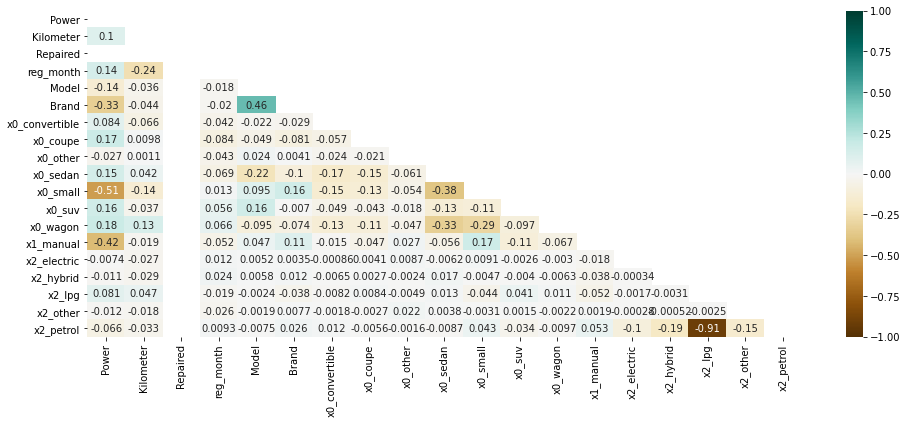

In [81]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(features_train.corr(), dtype=np.bool))
heatmap = sns.heatmap(features_train.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.show()

Очень высокая обратная корелляция между признаками petrol и lpg (-0.92)<br />
Во избежание Dummy-ловушки, один из них надо убрать.
Кроме того, чисто логически, есть взаимосвязь между брендом и моделью автомобиля. Имеет смысл убрать признак Brand

In [82]:
try:
    features_train = features_train.drop(['Brand', 'FuelType_lpg'], axis=1)
    features_test = features_test.drop(['Brand', 'FuelType_lpg'], axis=1)
except:
    features_train = features_train.drop(['Brand', 'x2_lpg'], axis=1)
    features_test = features_test.drop(['Brand', 'x2_lpg'], axis=1)

Данные готовы к обучению моделей

#### Итоги подготовки данных:

In [83]:
features_train.head()

,Power,Kilometer,Repaired,reg_month,Model,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_wagon,x1_manual,x2_electric,x2_hybrid,x2_other,x2_petrol
0,-0.35,0.58,True,-0.85,234.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
1,0.23,-0.76,True,-0.04,154.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00
2,-1.01,-1.03,True,0.54,151.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
3,-0.26,0.58,True,0.22,224.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
4,0.10,0.58,True,1.17,44.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00


In [84]:
features_test.head()

,Power,Kilometer,Repaired,reg_month,Model,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_wagon,x1_manual,x2_electric,x2_hybrid,x2_other,x2_petrol
0,0.59,0.58,True,-0.68,116.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
1,-0.44,0.58,True,0.61,237.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
2,0.06,0.58,True,0.08,59.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00
3,-1.01,0.58,True,-0.79,166.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00
4,-0.16,0.58,True,-0.75,204.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00


1. Удалены дубликаты записей;
2. Исправлены типы данных;
3. Данные о времени регистрации преобразованы в столбец с числом месяцев, прошедших с 1900 года;
4. Восстановлены пропущенные данные в признаках VehicleType, FuelType, Gearbox;
5. Удалены пропущенные данные в признаке Model;
6. Исправлены аномальные значения в признаке Power;
7. Данные разбиты на обучающую и тестовую выборки;
8. Выделены признаки и целевой признак;
9. Произведено масштабирование количественных признаков;
10. Произведено кодирование категориальных признаков;
11. Удалены признаки с высокой корелляцией;
12. Данные готовы к обучению моделей.

### Этап 4. Обучение моделей

Поскольку часть данных кодировано OrdinalEncoder, мы не можем использовать модель "Линейная регрессия".<br />
Поэтому для решения задачи будем использовать модели "DummyRegressor" (в качестве меры адекватности моделей), "Решающее дерево", "LightGBM" и "CatBoost". 

#### Модель "DummyRegressor"

In [85]:
%%time
strategies = ['mean','median']
dummy_time = []
dummy_score= []
for s in strategies:
    start = time()
    dummy = DummyRegressor(strategy = s)
    dummy.fit(features_train, target_train)
    scores = abs(cross_val_score(dummy, features_train,target_train, cv=5, scoring='neg_mean_squared_error'))**0.5
    final_score = abs(sum(scores) / len(scores))
    time_dummy = time() - start
    print('Стратегия "'+s+'". Средняя оценка качества модели: {:.2f}, время обучения: {:.2f} сек.'.format(final_score, time_dummy))

Стратегия "mean". Средняя оценка качества модели: 4563.23, время обучения: 0.09 сек.
Стратегия "median". Средняя оценка качества модели: 4855.25, время обучения: 0.07 сек.
CPU times: user 130 ms, sys: 7.97 ms, total: 138 ms
Wall time: 161 ms


In [86]:
%%time
strategies = ['mean','median']
dummy_time = []
dummy_score= []
min_score = 1000000
for i in range(len(strategies)):
    start = time()
    dummy = DummyRegressor(strategy = strategies[i])
    dummy.fit(features_train, target_train)
    scores = abs(cross_val_score(dummy, features_train,target_train, cv=5, scoring='neg_mean_squared_error'))**0.5
    dummy_score.append(abs(sum(scores) / len(scores)))
    dummy_time.append(time() - start)
    if dummy_score[i] < min_score:
        min_score = dummy_score[i]
        min_index = i
        
    print('Стратегия "'+s+'". Средняя оценка качества модели: {:.2f}, время обучения: {:.2f} сек.'.
          format(dummy_score[i], dummy_time[i]))
strategy_dummy = strategies[min_index]
result_dummy = dummy_score[min_index]
time_dummy = dummy_time[min_index]

Стратегия "median". Средняя оценка качества модели: 4563.23, время обучения: 0.06 сек.
Стратегия "median". Средняя оценка качества модели: 4855.25, время обучения: 0.08 сек.
CPU times: user 134 ms, sys: 0 ns, total: 134 ms
Wall time: 139 ms


In [87]:
print('Наилучший результат показывает модель "DummyRegressor" со стратегией "{0}":'.format(strategy_dummy))
print('\nСредняя оценка качества модели: {:.2f}, время обучения: {:.2f} сек.'.format(result_dummy, time_dummy))

Наилучший результат показывает модель "DummyRegressor" со стратегией "mean":

Средняя оценка качества модели: 4563.23, время обучения: 0.06 сек.


#### Модель "Решающее дерево"

In [88]:
%%time
start = time()
dtr = DecisionTreeRegressor(random_state=1176)
max_depth = [int(x) for x in np.linspace(start = 1, stop = 30, num = 10)]
param_dist = {'max_depth': max_depth}
rs = RandomizedSearchCV(dtr, 
                        param_dist, 
                        n_iter = 10, 
                        scoring = 'neg_mean_squared_error',
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=1176)
rs.fit(features_train, target_train)
model_tree = rs.best_estimator_
model_tree.params = rs.best_params_
result_tree = abs(rs.best_score_)**0.5
time_tree = time() - start

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 38.1 s, sys: 2.38 s, total: 40.5 s
Wall time: 42 s


In [89]:
print('Ветвей: {:.0f}.'.format(model_tree.params['max_depth']))
print('\nСредняя оценка качества модели: {:.2f}, время обучения: {:.2f} сек.'.format(result_tree, time_tree))

Ветвей: 13.

Средняя оценка качества модели: 2080.63, время обучения: 42.02 сек.


#### Модель " LightGBM"

In [90]:
%%time
start = time()
lgbm = LGBMRegressor()
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 101, num = 10)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 30, num = 10)]
learning_rate = [0.1, 0.25, 0.5, 0.75, 1]

param_dist = {'n_estimators': n_estimators,
              'max_depth':max_depth,
              'learning_rate': learning_rate
             }
rs = RandomizedSearchCV(lgbm, 
                        param_dist, 
                        n_iter = 10, 
                        scoring = 'neg_mean_squared_error',
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=1176)
rs.fit(features_train, target_train)
model_lgbm = rs.best_estimator_
model_lgbm.params = rs.best_params_
result_lgbm = abs(rs.best_score_)**0.5
time_lgbm = time() - start

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 2min 19s, sys: 3.24 s, total: 2min 22s
Wall time: 2min 23s


In [91]:
print('Деревьев: {:.0f}.'.format(model_lgbm.params['n_estimators']))
print('Ветвей: {:.0f}.'.format(model_lgbm.params['max_depth']))
print('Скорость обучения: {:.2f}.'.format(model_lgbm.params['learning_rate']))
print('\nСредняя оценка качества модели: {:.2f}, время обучения: {:.2f} сек.'.format(result_lgbm, time_lgbm))

Деревьев: 78.
Ветвей: 20.
Скорость обучения: 0.75.

Средняя оценка качества модели: 1855.08, время обучения: 143.66 сек.


#### Модель " CatBoost"

In [92]:
%%time
start = time()
cbr = CatBoostRegressor()
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 101, num = 10)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 30, num = 10)]
learning_rate = [0.1, 0.25, 0.5, 0.75, 1]


param_dist = {'n_estimators': n_estimators,
              'max_depth':max_depth,
              'learning_rate': learning_rate
             }
rs = RandomizedSearchCV(cbr, 
                        param_dist, 
                        n_iter = 10, 
                        scoring = 'neg_mean_squared_error',
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=1176)
rs.fit(features_train, target_train);
model_cbr = rs.best_estimator_
model_cbr.params = rs.best_params_
result_cbr = abs(rs.best_score_)**0.5
time_cbr = time() - start

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 3383.9121302	total: 73.9ms	remaining: 813ms
1:	learn: 2866.6707871	total: 95.3ms	remaining: 476ms
2:	learn: 2603.8548028	total: 115ms	remaining: 344ms
3:	learn: 2471.6460478	total: 134ms	remaining: 268ms
4:	learn: 2408.8300549	total: 153ms	remaining: 214ms
5:	learn: 2367.3651359	total: 171ms	remaining: 171ms
6:	learn: 2328.9609695	total: 190ms	remaining: 136ms
7:	learn: 2304.4644876	total: 210ms	remaining: 105ms
8:	learn: 2286.7371763	total: 235ms	remaining: 78.3ms
9:	learn: 2273.9428295	total: 253ms	remaining: 50.5ms
10:	learn: 2241.5730179	total: 271ms	remaining: 24.6ms
11:	learn: 2226.8936528	total: 290ms	remaining: 0us
0:	learn: 3438.8274696	total: 19.2ms	remaining: 211ms
1:	learn: 2863.1987176	total: 38.5ms	remaining: 192ms
2:	learn: 2617.2024598	total: 56.9ms	remaining: 171ms
3:	learn: 2500.5961413	total: 74.6ms	remaining: 149ms
4:	learn: 2415.5396627	total: 92.7ms	remaining: 130ms
5:	learn: 2375.2182696	total

In [93]:
print('Деревьев: {:.0f}.'.format(model_cbr.params['n_estimators']))
print('Ветвей: {:.0f}.'.format(model_cbr.params['max_depth']))
print('Скорость обучения: {:.2f}.'.format(model_cbr.params['learning_rate']))
print('\nСредняя оценка качества модели: {:.2f}, время обучения: {:.2f} сек.'.format(result_cbr, time_cbr))

Деревьев: 89.
Ветвей: 10.
Скорость обучения: 0.25.

Средняя оценка качества модели: 1868.78, время обучения: 69.80 сек.


#### Итоги обучения моделей:

Проведено моделирование с использованием моделей "DummyRegressor" (в качестве меры адекватности моделей), "Решающее дерево", "LightGBM" и "CatBoost". <br />
Оценка моделей проводилась на обучающей выборке метрикой RMSE.
Наилучшие значения метрики:<br /><br />

In [94]:
print('1. Модель "DummyRegressor":')
print('Стратегия:', strategy_dummy)
print('\nСредняя оценка качества модели: {:.2f}'.format(result_dummy))
print('Время обучения: {:.2f} сек.'.format(time_dummy))

1. Модель "DummyRegressor":
Стратегия: mean

Средняя оценка качества модели: 4563.23
Время обучения: 0.06 сек.


In [95]:
print('2. Модель "Решающее дерево":')
print('Ветвей: {:.0f}.'.format(model_tree.params['max_depth']))
print('\nСредняя оценка качества модели: {:.2f}'.format(result_tree))
print('Время обучения: {:.2f} сек.'.format(time_tree))

2. Модель "Решающее дерево":
Ветвей: 13.

Средняя оценка качества модели: 2080.63
Время обучения: 42.02 сек.


In [96]:
print('3. Модель "LightGBM":')
print('Деревьев: {:.0f}.'.format(model_lgbm.params['n_estimators']))
print('Ветвей: {:.0f}.'.format(model_lgbm.params['max_depth']))
print('Скорость обучения: {:.2f}.'.format(model_lgbm.params['learning_rate']))
print('\nСредняя оценка качества модели: {:.2f}'.format(result_lgbm))
print('Время обучения: {:.2f} сек.'.format(time_lgbm))

3. Модель "LightGBM":
Деревьев: 78.
Ветвей: 20.
Скорость обучения: 0.75.

Средняя оценка качества модели: 1855.08
Время обучения: 143.66 сек.


In [97]:
print('3. Модель "CatBoost":')
print('Деревьев: {:.0f}.'.format(model_cbr.params['n_estimators']))
print('Ветвей: {:.0f}.'.format(model_cbr.params['max_depth']))
print('Скорость обучения: {:.2f}.'.format(model_cbr.params['learning_rate']))
print('\nСредняя оценка качества модели: {:.2f}'.format(result_cbr))
print('Время обучения: {:.2f} сек.'.format(time_cbr))

3. Модель "CatBoost":
Деревьев: 89.
Ветвей: 10.
Скорость обучения: 0.25.

Средняя оценка качества модели: 1868.78
Время обучения: 69.80 сек.


### Этап 5. Анализ моделей

In [98]:
print('Наилучший результат показала модель "LightGBM" с параметрами:')
print('Деревьев: {:.0f}.'.format(model_lgbm.params['n_estimators']))
print('Ветвей: {:.0f}.'.format(model_lgbm.params['max_depth']))
print('Скорость обучения: {:.2f}.'.format(model_lgbm.params['learning_rate']))
print('\nСредняя оценка качества модели: {:.2f}'.format(result_lgbm))
print('Время обучения: {:.2f} сек.'.format(time_lgbm))

Наилучший результат показала модель "LightGBM" с параметрами:
Деревьев: 78.
Ветвей: 20.
Скорость обучения: 0.75.

Средняя оценка качества модели: 1855.08
Время обучения: 143.66 сек.


По времени она конкурирует с моделью "Решающее дерево" (при разных запусках и на разных машинах результат меняется), но проигрывает ему в метрике: 

In [99]:
print('Ветвей: {:.0f}.'.format(model_tree.params['max_depth']))
print('\nСредняя оценка качества модели: {:.2f}'.format(result_tree))
print('Время обучения: {:.2f} сек.'.format(time_tree))

Ветвей: 13.

Средняя оценка качества модели: 2080.63
Время обучения: 42.02 сек.


### Этап 6. Тестирование наилучшей модели

Проверим наилучшую модель на тестовой выборке

In [100]:
%%time 
start = time()
predict = model_lgbm.predict(features_test)
result = mean_squared_error(predict,target_test)**0.5
predict_time = time() - start

CPU times: user 408 ms, sys: 0 ns, total: 408 ms
Wall time: 334 ms


In [101]:
print('RMSE модели: {:.2f}'.format(result))
print('Время предсказания модели на тестовой выборке : {:.2f} сек.'.format(predict_time))

RMSE модели: 1853.19
Время предсказания модели на тестовой выборке : 0.33 сек.


RMSE модели на тестовой выборке еще лучше, чем на обучающей!

### Итоги проекта:

#### Анализ исходных данных:

1. Датасет содержит 354369 записей;
2. Присутствует 4 полных дубликата;
3. Часть признаков (VehicleType, Model, FuelType, Gearbox, Repaired) содержит пропуски;
4. Присутствует  слабая обратная корелляция между пробегом и ценой, а также очень слабая корреляция между мощностью двигателя и ценой;
5. Требуется приведение типов:

    - DateCrawled - к типу DateTime;
    - RegistrationYear, RegistrationMonth - объединить; 
    - DateCreated - к типу DateTime;
    - PostalCode - к типу string, добавить лидирующие нули до 6 символов;
    - Repaired - к типу boolean;
    - LastSeen - к типу DateTime.

6. NumberOfPictures содержит только нулевые данные;
7. признаки RegistrationYear, Power содержат сбойные данные (RegistrationMonth - 13 месяцев, Power - мощность 0 и 20000 л.с.

#### Подготовка данных

1. Удалены дубликаты записей;
2. Исправлены типы данных;
3. Данные о времени регистрации преобразованы в столбец с числом месяцев, прошедших с 1900 года;
4. Восстановлены пропущенные данные в признаках VehicleType, FuelType, Gearbox;
5. Удалены пропущенные данные в признаке Model;
6. Исправлены аномальные значения в признаке Power;
7. Данные разбиты на обучающую и тестовую выборки;
8. Выделены признаки и целевой признак;
9. Произведено масштабирование количественных признаков;
10. Произведено кодирование категориальных признаков;
11. Удалены признаки с высокой корелляцией;
12. Данные подготовлены к обучению моделей.

#### Моделирование:

Проведено моделирование с использованием моделей "DummyRegressor" (в качестве меры адекватности моделей), "Решающее дерево", "LightGBM" и "CatBoost". <br />
Оценка моделей проводилась на обучающей выборке метрикой RMSE.

In [102]:
print('1. Модель "DummyRegressor":')
print('Стратегия:', strategy_dummy)
print('\nСредняя оценка качества модели: {:.2f}'.format(result_dummy))
print('Время обучения: {:.2f} сек.'.format(time_dummy))

1. Модель "DummyRegressor":
Стратегия: mean

Средняя оценка качества модели: 4563.23
Время обучения: 0.06 сек.


In [103]:
print('2. Модель "Решающее дерево":')
print('Ветвей: {:.0f}.'.format(model_tree.params['max_depth']))
print('\nСредняя оценка качества модели: {:.2f}'.format(result_tree))
print('Время обучения: {:.2f} сек.'.format(time_tree))

2. Модель "Решающее дерево":
Ветвей: 13.

Средняя оценка качества модели: 2080.63
Время обучения: 42.02 сек.


In [104]:
print('3. Модель "LightGBM":')
print('Деревьев: {:.0f}.'.format(model_lgbm.params['n_estimators']))
print('Ветвей: {:.0f}.'.format(model_lgbm.params['max_depth']))
print('Скорость обучения: {:.2f}.'.format(model_lgbm.params['learning_rate']))
print('\nСредняя оценка качества модели: {:.2f}'.format(result_lgbm))
print('Время обучения: {:.2f} сек.'.format(time_lgbm))

3. Модель "LightGBM":
Деревьев: 78.
Ветвей: 20.
Скорость обучения: 0.75.

Средняя оценка качества модели: 1855.08
Время обучения: 143.66 сек.


In [105]:
print('3. Модель "CatBoost":')
print('Деревьев: {:.0f}.'.format(model_cbr.params['n_estimators']))
print('Ветвей: {:.0f}.'.format(model_cbr.params['max_depth']))
print('Скорость обучения: {:.2f}.'.format(model_cbr.params['learning_rate']))
print('\nСредняя оценка качества модели: {:.2f}'.format(result_cbr))
print('Время обучения: {:.2f} сек.'.format(time_cbr))

3. Модель "CatBoost":
Деревьев: 89.
Ветвей: 10.
Скорость обучения: 0.25.

Средняя оценка качества модели: 1868.78
Время обучения: 69.80 сек.


#### Выбор модели

In [106]:
print('Наилучший результат показала модель "LightGBM" с параметрами:')
print('Деревьев: {:.0f}.'.format(model_lgbm.params['n_estimators']))
print('Ветвей: {:.0f}.'.format(model_lgbm.params['max_depth']))
print('Скорость обучения: {:.2f}.'.format(model_lgbm.params['learning_rate']))
print()
print('Итоговая метрика RMSE модели:')
print('- на обучающей выборке: {:.2f}'.format(result_lgbm))
print('- на тестовой выборке: {:.2f}'.format(result))
print()
print('Время обучения модели: {:.2f} сек.'.format(time_lgbm))
print('Время предсказания модели на тестовой выборке : {:.2f} сек.'.format(predict_time))

Наилучший результат показала модель "LightGBM" с параметрами:
Деревьев: 78.
Ветвей: 20.
Скорость обучения: 0.75.

Итоговая метрика RMSE модели:
- на обучающей выборке: 1855.08
- на тестовой выборке: 1853.19

Время обучения модели: 143.66 сек.
Время предсказания модели на тестовой выборке : 0.33 сек.
